# Course: ICS 574
# Prject: Alchemists Project - EDA
- Date: May 1st 2024
- Project Members
    - AHMED DHAFER ALQARNI, ID: 201453160
    - WALEED ABDULLAH ALFAIFI, ID: 201640920
    - ALGHAMDI, BANDAR, ID: 202206560

The project is divided into 6 parts
1. Importing the libraries
2. Preprocessing the data
3. Model Selection

    3.1 Decision Tree Classifier Model

    3.2 Decision Tree Regressor Model

    3.3 GBTRegressor Model

    3.4 Random Forest Regressor Model

    3.5 Support Vector Classifier Model

    3.6 Support Vector Regressor Model
    
4. Model Evaluation

   
    
5. Model Prediction

In [73]:
#import needed libraries
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import seaborn as sns
import numpy as np
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Create a Spark session
spark = SparkSession.builder.appName("MarketAlchemists").getOrCreate()
spark


# 1. Data Preprocessing

- Preprocess the stock data as done in the EDA Part previously we have seen that the data is not clean and has missing values in Phase 1 of the project
- below code is to import the data, clean it, rename columns, and merge the dataframes as done in the EDA Phase 1 part

In [74]:
# Load the datasets as pandas DataFrames
stocks_df = pd.read_csv("./datasets/Tadawul_stcks.csv")
brent_df = pd.read_csv("./datasets/BrentOilPrices.csv")
gold_df = pd.read_csv("./datasets/Gold_Daily.csv")

# hide warnings for better readability
import warnings
warnings.filterwarnings('ignore')

# Preprocess the stock data as done in the EDA Part
# previously we have seen that the data is not clean and has missing values in Phase 1 of the project
# below code is to clean the data, rename the columns and merge the dataframes
# as done in the EDA Phase 1 part
stocks_specific_df = stocks_df[(stocks_df['sectoer'] == 'Energy') | (stocks_df['sectoer'] == 'Materials')]
stocks_specific_df.rename(columns={'date': 'Date'}, inplace=True)
stocks_specific_df.rename(columns={'close': 'Stock_Price'}, inplace=True)
stocks_specific_df['Date'] = pd.to_datetime(stocks_specific_df['Date'])
brent_df['Date'] = pd.to_datetime(brent_df['Date'])
gold_df['Date'] = pd.to_datetime(gold_df['Date'])
brent_df.rename(columns={'Price': 'Brent_Price'}, inplace=True)
gold_df.rename(columns={'Price': 'Gold_Price'}, inplace=True)
stocks_specific_df.rename(columns={'sectoer': 'Sector'}, inplace=True)
brent_df = brent_df[['Date', 'Brent_Price']]
gold_df = gold_df[['Date', 'Gold_Price']]
stocks_specific_df.fillna(method='ffill', inplace=True)
stocks_brent_df = pd.merge(stocks_specific_df, brent_df, on='Date', how='inner')
stocks_brent_gold_df = pd.merge(stocks_brent_df, gold_df, on='Date', how='inner')

# define a function that does all the above data preprocessing steps so we can use it before we try different models with original data
def preprocess_data(stocks_df, brent_df, gold_df):
    stocks_specific_df = stocks_df[(stocks_df['sectoer'] == 'Energy') | (stocks_df['sectoer'] == 'Materials')]
    stocks_specific_df.rename(columns={'date': 'Date'}, inplace=True)
    stocks_specific_df.rename(columns={'close': 'Stock_Price'}, inplace=True)
    stocks_specific_df['Date'] = pd.to_datetime(stocks_specific_df['Date'])
    brent_df['Date'] = pd.to_datetime(brent_df['Date'])
    gold_df['Date'] = pd.to_datetime(gold_df['Date'])
    brent_df.rename(columns={'Price': 'Brent_Price'}, inplace=True)
    gold_df.rename(columns={'Price': 'Gold_Price'}, inplace=True)
    stocks_specific_df.rename(columns={'sectoer': 'Sector'}, inplace=True)
    brent_df = brent_df[['Date', 'Brent_Price']]
    gold_df = gold_df[['Date', 'Gold_Price']]
    stocks_specific_df.fillna(method='ffill', inplace=True)
    stocks_brent_df = pd.merge(stocks_specific_df, brent_df, on='Date', how='inner')
    stocks_brent_gold_df = pd.merge(stocks_brent_df, gold_df, on='Date', how='inner')
    return stocks_brent_gold_df


In [8]:
# Create a Spark DataFrame
stocks_brent_gold_df_spark = spark.createDataFrame(stocks_brent_gold_df)

In [10]:
# print columns of the DataFrame
stocks_brent_gold_df_spark.columns

['symbol',
 'name',
 'trading_name ',
 'Sector',
 'Date',
 'open',
 'high',
 'low',
 'Stock_Price',
 'change',
 'perc_Change',
 'volume_traded ',
 'value_traded',
 'no_trades ',
 'Brent_Price',
 'Gold_Price']

# 2. Model Selection

In this section, we cover the usage of various models to identify the best option to go with: Decision Tree, Regression Tree, SVM

# 2.1 Model Selection: Decision Tree Model

In [11]:
# adding a new Price_Change column to the DataFrame, since the label should be categorical in Decision Trees and later indexed
# this column will be used to determine if the stock price increased or decreased from the previous day


stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Price_Change",
                        F.when(F.col("Stock_Price") > F.lag("Stock_Price").over(Window.orderBy("Date")), "Up")
                        .otherwise("Down"))

# Convert Price_Change to a numerical label
label_indexer = StringIndexer(inputCol="Price_Change", outputCol="label")
stocks_brent_gold_df_spark = label_indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)

24/04/29 10:34:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 10:34:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 10:34:53 WARN TaskSetManager: Stage 0 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 10:34:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 10:34:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [12]:
# Create StringIndexers for categorical columns
name_indexer = StringIndexer(inputCol="name", outputCol="nameIndex")
sector_indexer = StringIndexer(inputCol="Sector", outputCol="SectorIndex")
symbol_indexer = StringIndexer(inputCol="symbol", outputCol="symbolIndex")

In [13]:
# Create a VectorAssembler for the features
assembler = VectorAssembler(inputCols=["Stock_Price", "Brent_Price", "Gold_Price"], outputCol="features")
stocks_brent_gold_df_spark = assembler.transform(stocks_brent_gold_df_spark)

In [14]:
# Train-test split
splits = stocks_brent_gold_df_spark.randomSplit([0.8, 0.2])
train = splits[0]
test = splits[1]

In [16]:
# Define the DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
pipeline = Pipeline(stages=[name_indexer, sector_indexer, symbol_indexer, assembler, dt])
model = dt.fit(train) # Train the model on the training data

24/04/29 10:38:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 10:38:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 10:38:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 10:38:20 WARN TaskSetManager: Stage 3 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 10:38:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 10:38:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 10:38:20 WARN WindowExec:

In [17]:
# Make predictions on the test data
predictions = model.transform(test)

In [19]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

24/04/29 10:39:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 10:39:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 10:39:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 10:39:13 WARN TaskSetManager: Stage 31 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 10:39:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 10:39:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Accuracy: 0.7102054064079381


In [35]:
# create a table for the predictions and the actual labels for SABIC for dates after 2018
predictions.createOrReplaceTempView("predictions")
sabic_predictions = spark.sql("SELECT name, Date, Stock_Price, Brent_Price, Gold_Price, label, prediction FROM predictions WHERE name = 'Saudi Basic Industries Corp.' AND Date > '2018-01-01'").show(150)


24/04/29 10:47:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 10:47:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 10:47:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 10:47:12 WARN TaskSetManager: Stage 71 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 10:47:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 10:47:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------------------+-------------------+-----------+-----------+----------+-----+----------+
|                name|               Date|Stock_Price|Brent_Price|Gold_Price|label|prediction|
+--------------------+-------------------+-----------+-----------+----------+-----+----------+
|Saudi Basic Indus...|2018-01-03 00:00:00|      101.5|      67.85|    1404.0|  0.0|       0.0|
|Saudi Basic Indus...|2018-01-10 00:00:00|     101.68|      69.79|    1408.3|  0.0|       0.0|
|Saudi Basic Indus...|2018-01-11 00:00:00|     101.54|      70.36|    1411.4|  0.0|       0.0|
|Saudi Basic Indus...|2018-01-16 00:00:00|     106.16|       69.4|    1428.1|  0.0|       0.0|
|Saudi Basic Indus...|2018-01-17 00:00:00|     107.24|      69.19|    1431.0|  0.0|       0.0|
|Saudi Basic Indus...|2018-02-12 00:00:00|     105.06|       62.2|    1420.9|  0.0|       0.0|
|Saudi Basic Indus...|2018-02-15 00:00:00|     105.29|      62.86|    1451.5|  0.0|       0.0|
|Saudi Basic Indus...|2018-02-26 00:00:00|     105

24/04/29 10:48:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 10:48:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 10:48:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 10:48:14 WARN TaskSetManager: Stage 74 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 10:48:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 10:48:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


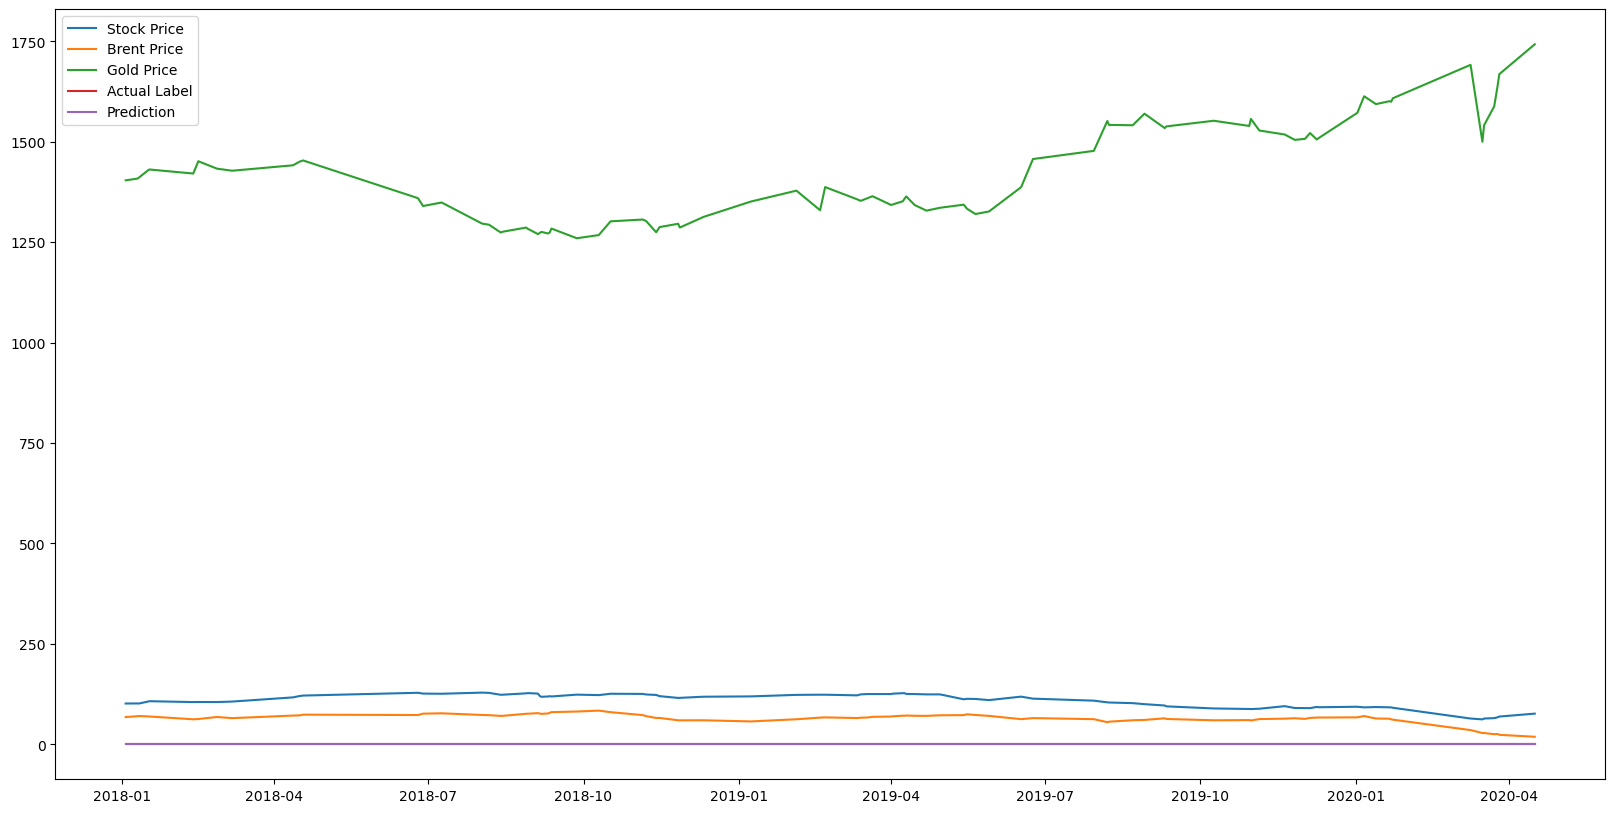

In [36]:
# plot the predictions and the actual labels for SABIC for dates after 2018
sabic_predictions_df = predictions.toPandas()
sabic_predictions_df = sabic_predictions_df[sabic_predictions_df['name'] == 'Saudi Basic Industries Corp.']
sabic_predictions_df = sabic_predictions_df[sabic_predictions_df['Date'] > '2018-01-01']
plt.figure(figsize=(20, 10))
plt.plot(sabic_predictions_df['Date'], sabic_predictions_df['Stock_Price'], label='Stock Price')
plt.plot(sabic_predictions_df['Date'], sabic_predictions_df['Brent_Price'], label='Brent Price')
plt.plot(sabic_predictions_df['Date'], sabic_predictions_df['Gold_Price'], label='Gold Price')
plt.plot(sabic_predictions_df['Date'], sabic_predictions_df['label'], label='Actual Label')
plt.plot(sabic_predictions_df['Date'], sabic_predictions_df['prediction'], label='Prediction')
plt.legend()
plt.show()

# 2.2 Model Selection: Regression Model

In [9]:
# before we try different models, we need to preprocess the data again
stocks_brent_gold_df = preprocess_data(stocks_df, brent_df, gold_df)

In [10]:
# because we are going to use the DecisionTreeRegressor, we need to convert the categorical data to numerical data
indexer = StringIndexer(inputCol="Sector", outputCol="SectorIndex")
indexed = indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)


24/04/29 11:59:45 WARN TaskSetManager: Stage 0 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


In [11]:
indexed.show()

+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+
|symbol|                name|  trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|SectorIndex|
+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+
|  2030|Saudi Arabia Refi...|          SARCO|   Energy|2020-03-05 00:00:00|35.55|35.85| 34.9|       34.9|  -0.4|      -1.13|      436609.0|  1.53990735E7|     804.0|      51.29|    1690.5|        1.0|
|  2222|Saudi Arabian Oil...|   SAUDI ARAMCO|   Energy|2020-03-05 00:00:00|33.05| 33.2|32.95|       33.0| -0.05|      -0.15|     3969243.0|1.3103890695E8|    4576.0|      51.29|    1690.5|        

In [12]:
# index the name of the stock
indexer = StringIndexer(inputCol="name", outputCol="StockIndex")
indexed = indexer.fit(indexed).transform(indexed)

24/04/29 11:59:52 WARN TaskSetManager: Stage 4 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


In [13]:
# verify the indexing
indexed.show()

+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+----------+
|symbol|                name|  trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|SectorIndex|StockIndex|
+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+----------+
|  2030|Saudi Arabia Refi...|          SARCO|   Energy|2020-03-05 00:00:00|35.55|35.85| 34.9|       34.9|  -0.4|      -1.13|      436609.0|  1.53990735E7|     804.0|      51.29|    1690.5|        1.0|      18.0|
|  2222|Saudi Arabian Oil...|   SAUDI ARAMCO|   Energy|2020-03-05 00:00:00|33.05| 33.2|32.95|       33.0| -0.05|      -0.15|     3969243.0|1.3103890695E

In [14]:
# create a feature vector by combining the features that we are going to use
vectorAssembler = VectorAssembler(inputCols=["Stock_Price", "volume_traded ", "value_traded", "no_trades ", "Brent_Price", "Gold_Price"], outputCol="features")

In [16]:
# Create a VectorAssembler for the features
assembledData = vectorAssembler.transform(indexed)

In [17]:
stocks_brent_gold_df_spark = assembledData

In [19]:
# show the datframe to verify features column
stocks_brent_gold_df_spark.show(truncate=False)

+------+----------------------------------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+----------+---------------------------------------------------+
|symbol|name                                          |trading_name   |Sector   |Date               |open |high |low  |Stock_Price|change|perc_Change|volume_traded |value_traded  |no_trades |Brent_Price|Gold_Price|SectorIndex|StockIndex|features                                           |
+------+----------------------------------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+----------+---------------------------------------------------+
|2030  |Saudi Arabia Refineries Co.                   |SARCO          |Energy   |2020-03-05 00:00:00|35.55|35.85|34.9 |34.9       

In [20]:
# cross validation on spark doesn't respect the time in time-series; test:train is better on spark
# equivilant of sklearn.model_selection.TimeSeriesSplit
# else: hold-out method
# later on, use other models: SVM (super vector machine) / MLP / etc

In [21]:
# split the data into training and testing
# 80% of the data is used for training and 20% for testing
(trainingData, testData) = stocks_brent_gold_df_spark.randomSplit([0.8, 0.2])


In [22]:
# Define the DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol="features", labelCol="StockIndex")

In [23]:
# define the evaluator
# note the metricName parameter is rmse, which stands for Root Mean Squared Error. This is the default metric for regression problems.
# Other metrics include r2 (R squared) and mae (Mean Absolute Error)
# see the documentation for more details: https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="StockIndex", predictionCol="prediction", metricName="rmse")

In [24]:
# Define the grid of hyperparameters
# We will use a ParamGridBuilder to construct a grid of parameters to search over.
# With 3 values for dt.maxDepth and 5 values for dt.maxBins, this grid will have 3 x 5 = 15 parameter settings for CrossValidator to choose from.
# see the documentation for more details: https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.tuning.ParamGridBuilder
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [2, 3, 4, 5, 6, 7, 8, 9, 10]) \
    .addGrid(dt.maxBins, [10, 20, 40, 80, 100]) \
    .build()

In [25]:
# Define the CrossValidator
# We will use a CrossValidator to select the best model.
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# see the documentation for more details: https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator
cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

In [26]:
# fit the cv model with the assembled data
cvModel = cv.fit(stocks_brent_gold_df_spark)

24/04/29 15:42:10 WARN TaskSetManager: Stage 11 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 15:42:10 WARN TaskSetManager: Stage 13 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 15:42:10 WARN TaskSetManager: Stage 14 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 15:42:10 WARN TaskSetManager: Stage 16 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 15:42:11 WARN TaskSetManager: Stage 18 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 15:42:11 WARN TaskSetManager: Stage 20 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 15:42:11 WARN TaskSetManager: Stage 21 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/

In [27]:
# get the average cross-validated RMSE
# note the RMSE is the root of the average of the squares of the differences between the predicted and the actual values
# see the documentation for more details: https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator

# the higher the RMSE, the worse the model
# the lower the RMSE, the better the model
# the RMSE is a measure of the quality of the model
# the RMSE is scale-dependent
# the RMSE can be used to compare different models
# the RMSE can be used to compare different transformations of the same model
# the RMSE can be used to compare different models on different datasets
# the RMSE can be used to compare different models on the same dataset
# the RMSE can be used to compare different models on the same dataset with different target variables
# the RMSE can be used to compare different models on the same dataset with the same target variable
# the RMSE can be used to compare different models on the same dataset with the same target variable and different features
# the RMSE can be used to compare different models on the same dataset with the same target variable and the same features
# the RMSE can be used to compare different models on the same dataset with the same target variable and the same features and different hyperparameters
# the RMSE can be used to compare different models on the same dataset with the same target variable and the same features and the same hyperparameters
# the RMSE value of 0 means the model is perfect
# the RMSE value of 9 means the model is good?
avg_rmse = np.mean(cvModel.avgMetrics)
print("Average RMSE: ", avg_rmse)

Average RMSE:  9.57401754967


In [28]:
# print all the parameters of the best model
print(cvModel.bestModel.extractParamMap())

{Param(parent='DecisionTreeRegressor_72b1e044f2a8', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='DecisionTreeRegressor_72b1e044f2a8', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='DecisionTreeRegressor_72b1e044f2a8', name='featuresCol', doc='features column name.'): 'features', Param(parent='DecisionTreeRegressor_72b1e044f2a8', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: variance'): 'variance', Para

In [29]:
# print the RMSE of all the models, just to view the difference in the cross-validated RMSE
for rmse in cvModel.avgMetrics:
    print(rmse)

10.522291912561494
10.522291912561494
10.521084551055708
10.51280981321889
10.513402909162403
10.105402825818217
10.104516314479561
10.078112506357273
10.068864457527516
10.06684320937565
9.892983968287458
9.889723276827738
9.828495107838203
9.821123434486285
9.813828512329861
9.71373768243144
9.707899114952871
9.635758587698248
9.627275129878342
9.605273675223932
9.565798877735235
9.5341368758327
9.470339779137046
9.464775168352896
9.459239826354809
9.44437240344195
9.382796425186196
9.330419733140833
9.32327721967102
9.309536673126363
9.318386259705175
9.227781673043385
9.180582890095703
9.153743129328205
9.16717438667466
9.186272620448268
9.080836043516497
9.040114764571014
8.989954591034191
9.007446180757652
9.064959314858148
8.945241550955789
8.904468834086398
8.852746870645689
8.874668741377592


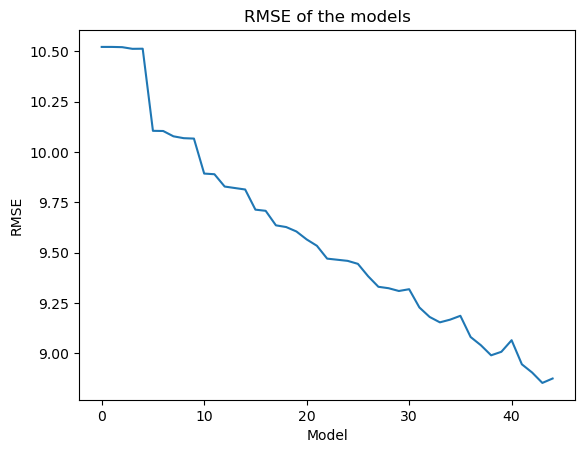

In [32]:
# plot all the RMSE values of the models to see the difference in the cross-validated RMSE
plt.plot(cvModel.avgMetrics)
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE of the models')
plt.show()

In [33]:
# print the feature importances

# The feature importances represent the importance of each feature in the decision tree model.

# The feature importances are calculated based on the information gain provided by each feature in splitting the data.

# The higher the feature importance, the more important the feature is in making predictions.



# get the feature importances
feature_importances = cvModel.bestModel.featureImportances

# create a DataFrame to display the feature importances
feature_importances_df = pd.DataFrame(list(zip(stocks_brent_gold_df_spark.columns[2:], feature_importances)),
                                      columns=["Feature", "Importance"])

# sort the DataFrame by feature importance in descending order
feature_importances_df = feature_importances_df.sort_values("Importance", ascending=False)

# display the feature importances
print(feature_importances_df)

         Feature  Importance
0  trading_name     0.437826
5            low    0.280224
3           open    0.112374
4           high    0.077254
1         Sector    0.069495
2           Date    0.022828


In [34]:
# print the feature importances
# Feature importances describe the relative importance of each feature in making accurate predictions.
# The higher the value, the more important the feature is.
# Feature importances can help you understand which features are most influential in your model's predictions.
# Feature importances can guide feature selection and model interpretation.

# get the feature importances
feature_importances = cvModel.bestModel.featureImportances

# create a pandas DataFrame to display the feature importances
feature_importances_df = pd.DataFrame(list(zip(["Stock_Price", "Brent_Price", "Gold_Price"], feature_importances)),
                                      columns=["Feature", "Importance"])

# display the feature importances
print(feature_importances_df)

       Feature  Importance
0  Stock_Price    0.437826
1  Brent_Price    0.069495
2   Gold_Price    0.022828


In [35]:
# print the hyperparameters of the best model
# The hyperparameters of the best model can provide insights into the configuration that yielded the best performance.
# Understanding the hyperparameters can help you tune future models and optimize their performance.
# The hyperparameters of the best model can guide further experimentation and refinement of the model.
print(cvModel.bestModel._java_obj.getMaxDepth())
print(cvModel.bestModel._java_obj.getMaxBins())

10
80


+-------------------+-----------+------------------+
|               Date|Stock_Price|        prediction|
+-------------------+-----------+------------------+
|2020-01-23 00:00:00|       90.9| 9.173453996983408|
|2020-01-22 00:00:00|       91.8|12.083710407239819|
|2020-01-21 00:00:00|       92.0| 9.173453996983408|
|2020-01-20 00:00:00|       92.9|12.083710407239819|
|2020-01-16 00:00:00|       92.8| 9.173453996983408|
|2020-01-15 00:00:00|       92.4| 9.173453996983408|
|2020-01-14 00:00:00|       93.2| 9.173453996983408|
|2020-01-13 00:00:00|       92.7| 9.173453996983408|
|2020-01-09 00:00:00|       92.0| 9.173453996983408|
|2020-01-08 00:00:00|       90.5| 9.173453996983408|
|2020-01-07 00:00:00|       91.0| 9.173453996983408|
|2020-01-06 00:00:00|       91.9| 9.173453996983408|
|2020-01-02 00:00:00|       93.4| 9.173453996983408|
|2020-01-01 00:00:00|       93.1| 9.173453996983408|
|2019-12-31 00:00:00|       93.9| 9.173453996983408|
|2019-12-30 00:00:00|       93.7| 2.9354838709

24/04/29 15:50:55 WARN TaskSetManager: Stage 4096 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 15:50:55 WARN TaskSetManager: Stage 4097 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


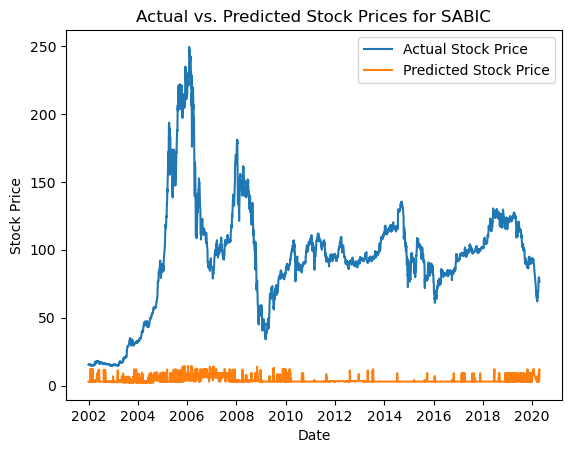

In [36]:
# create a table for SABIC actual and predicted stock prices

# get the predictions
predictions = cvModel.transform(stocks_brent_gold_df_spark)

# select the relevant columns for SABIC stock prices
sabic_predictions = predictions.select("Date", "Stock_Price", "prediction").filter(predictions.name == "Saudi Basic Industries Corp.")

# display the actual and predicted stock prices for SABIC
sabic_predictions.show()

# plot the actual and predicted stock prices for SABIC
sns.lineplot(data=sabic_predictions.toPandas(), x="Date", y="Stock_Price", label="Actual Stock Price")
sns.lineplot(data=sabic_predictions.toPandas(), x="Date", y="prediction", label="Predicted Stock Price")
plt.title("Actual vs. Predicted Stock Prices for SABIC")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

- we notice that the DecisionTreeRegressor model is not performing well; this can be due to the fact that the cross-validation is not respecting the time in the time-series data

- we can try to use the test:train split method instead of cross-validation to verify if it yeilds better results

In [37]:
# split the data into training and testing
# 80% of the data is used for training and 20% for testing
(trainingData, testData) = stocks_brent_gold_df_spark.randomSplit([0.8, 0.2])

# Define the DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol="features", labelCol="StockIndex")

# Train the model on the training data
model = dt.fit(trainingData)

# Make predictions on the test data
predictions = model.transform(testData)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="StockIndex", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

24/04/29 15:57:40 WARN TaskSetManager: Stage 4099 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 15:57:40 WARN TaskSetManager: Stage 4100 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 15:57:40 WARN TaskSetManager: Stage 4102 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 15:57:41 WARN TaskSetManager: Stage 4104 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 15:57:41 WARN TaskSetManager: Stage 4106 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 15:57:41 WARN TaskSetManager: Stage 4108 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 15:57:41 WARN TaskSetManager: Stage 4110 contains a task of very large size (1102 KiB). The maximum recommended task size is 10

Root Mean Squared Error (RMSE): 9.590728564371908


In [38]:
# we do non-random split to respect the time in the time-series data
# we split the data by date
# the training data is before 2018 and the testing data is after 2018
trainingData2 = stocks_brent_gold_df_spark.filter(stocks_brent_gold_df_spark.Date < '2018-01-01')
testData2 = stocks_brent_gold_df_spark.filter(stocks_brent_gold_df_spark.Date >= '2018-01-01')

# Define the DecisionTreeRegressor
dt2 = DecisionTreeRegressor(featuresCol="features", labelCol="StockIndex")

# Train the model on the training data
model2 = dt.fit(trainingData2)

# Make predictions on the test data
predictions2 = model2.transform(testData2)

# Evaluate the model
evaluator2 = RegressionEvaluator(labelCol="StockIndex", predictionCol="prediction", metricName="rmse")
rmse2 = evaluator2.evaluate(predictions2)
print("Root Mean Squared Error (RMSE):", rmse2)

24/04/29 15:59:48 WARN TaskSetManager: Stage 4115 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 15:59:48 WARN TaskSetManager: Stage 4116 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 15:59:48 WARN TaskSetManager: Stage 4117 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 15:59:48 WARN TaskSetManager: Stage 4119 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 15:59:48 WARN TaskSetManager: Stage 4121 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 15:59:48 WARN TaskSetManager: Stage 4123 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 15:59:48 WARN TaskSetManager: Stage 4125 contains a task of very large size (1102 KiB). The maximum recommended task size is 10

Root Mean Squared Error (RMSE): 12.903686166376568


- from above, we see Regression isn't yeilding good results

# 2.3 Model Selection: GBTRgressor

Gradient-Boosted Trees (GBTs) learning algorithm for regression. It supports both continuous and categorical features.

In [42]:
# before we try different models, we need to preprocess the data again
stocks_brent_gold_df = preprocess_data(stocks_df, brent_df, gold_df)

In [ ]:
# because we are going to use the DecisionTreeRegressor, we need to convert the categorical data to numerical data
indexer = StringIndexer(inputCol="Sector", outputCol="SectorIndex")
indexed = indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)

In [53]:
# because we are going to use the DecisionTreeRegressor, we need to convert the categorical data to numerical data
indexer = StringIndexer(inputCol="Sector", outputCol="SectorIndex")
indexed = stocks_brent_gold_df_spark

In [56]:
# change StockIndex to label
indexed = indexed.withColumnRenamed("StockIndex", "label")

In [57]:
indexed.show()

+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+-----+--------------------+
|symbol|                name|  trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|SectorIndex|label|            features|
+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+-----+--------------------+
|  2030|Saudi Arabia Refi...|          SARCO|   Energy|2020-03-05 00:00:00|35.55|35.85| 34.9|       34.9|  -0.4|      -1.13|      436609.0|  1.53990735E7|     804.0|      51.29|    1690.5|        1.0| 18.0|[34.9,436609.0,1....|
|  2222|Saudi Arabian Oil...|   SAUDI ARAMCO|   Energy|2020-03-05 00:00:00|33.05| 33.2|3

In [65]:
# implement a model that predicts the stock price of SABIC
# we have various models to choose from, such as DecisionTreeRegressor, RandomForestRegressor, GBTRegressor, etc.
# each model has its own strengths and weaknesses
# we can use the GBTRgressor model to predict the stock price of SABIC
# the GBTRegressor model is an ensemble model that uses multiple decision trees to make predictions
# the GBTRegressor model is a powerful model that can capture complex relationships in the data
# the GBTRegressor model is a popular model for regression problems
# the GBTRegressor model is a good choice for predicting the stock price of SABIC
from pyspark.ml.regression import GBTRegressor
# split the data into training and testing
# 80% of the data is used for training and 20% for testing
(trainingData, testData) = indexed.randomSplit([0.8, 0.2])

# Define the GBTRegressor
gbt = GBTRegressor(featuresCol="features", labelCol="label")

# Train the model on the training data
model = gbt.fit(trainingData)

# Make predictions on the test data
predictions = model.transform(testData)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

24/04/29 16:23:31 WARN TaskSetManager: Stage 4136 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 16:23:31 WARN TaskSetManager: Stage 4137 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 16:23:32 WARN TaskSetManager: Stage 4139 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 16:23:32 WARN TaskSetManager: Stage 4141 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 16:23:32 WARN TaskSetManager: Stage 4143 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 16:23:32 WARN TaskSetManager: Stage 4145 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 16:23:32 WARN TaskSetManager: Stage 4147 contains a task of very large size (1102 KiB). The maximum recommended task size is 10

Root Mean Squared Error (RMSE): 9.01677305623062


24/04/29 16:23:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [69]:
# implement a Stochastic Gradient Descent - SGD
# split the data into training and testing
# 80% of the data is used for training and 20% for testing
(trainingData, testData) = indexed.randomSplit([0.8, 0.2])

# Define the Stochastic Gradient Descent - SGD
from pyspark.ml.regression import GeneralizedLinearRegression
sgd = GeneralizedLinearRegression(featuresCol="features", labelCol="label")

# Train the model on the training data
model = sgd.fit(trainingData)

# Make predictions on the test data
predictions = model.transform(testData)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

24/04/29 18:26:37 WARN Instrumentation: [5d6f5b9d] regParam is zero, which might cause numerical instability and overfitting.
24/04/29 18:26:37 WARN TaskSetManager: Stage 4353 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


Root Mean Squared Error (RMSE): 10.802688378472856


24/04/29 18:26:38 WARN TaskSetManager: Stage 4355 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


# 2.4 Model Selection: SVMModel

In [77]:
indexed.show()

+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+-----+--------------------+
|symbol|                name|  trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|SectorIndex|label|            features|
+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+-----+--------------------+
|  2030|Saudi Arabia Refi...|          SARCO|   Energy|2020-03-05 00:00:00|35.55|35.85| 34.9|       34.9|  -0.4|      -1.13|      436609.0|  1.53990735E7|     804.0|      51.29|    1690.5|        1.0| 18.0|[34.9,436609.0,1....|
|  2222|Saudi Arabian Oil...|   SAUDI ARAMCO|   Energy|2020-03-05 00:00:00|33.05| 33.2|3

In [81]:
# drop the label column
indexed = indexed.drop("label")

In [79]:
# add a new column to the DataFrame that indicates if the stock price increased or decreased from the previous day, with label 1 for increase and 0 for decrease
# this column will be used as the label for the model
indexed = indexed.withColumn("Price_Change",
                        F.when(F.col("Stock_Price") > F.lag("Stock_Price").over(Window.orderBy("Date")), 1)
                        .otherwise(0))

# Convert Price_Change to a numerical label
label_indexer = StringIndexer(inputCol="Price_Change", outputCol="label")
indexed = label_indexer.fit(indexed).transform(indexed)

24/04/29 20:53:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:53:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:53:56 WARN TaskSetManager: Stage 4360 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 20:53:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:53:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [83]:
# rename Price_Change column to label
indexed = indexed.withColumnRenamed("Price_Change", "label")

In [84]:
indexed.show()

+------+--------------------+--------------+---------+-------------------+-----+-----+-----+-----------+-------+-----------+--------------+-------------+----------+-----------+----------+-----------+--------------------+-----+
|symbol|                name| trading_name |   Sector|               Date| open| high|  low|Stock_Price| change|perc_Change|volume_traded | value_traded|no_trades |Brent_Price|Gold_Price|SectorIndex|            features|label|
+------+--------------------+--------------+---------+-------------------+-----+-----+-----+-----------+-------+-----------+--------------+-------------+----------+-----------+----------+-----------+--------------------+-----+
|  4030|National Shipping...|         BAHRI|   Energy|2001-12-31 00:00:00| 9.25| 9.25| 9.25|       9.25|   9.25|        0.0|      256935.0|    2367154.5|      44.0|      19.35|     278.7|        1.0|[9.25,256935.0,23...|    0|
|  2010|Saudi Basic Indus...|         SABIC|Materials|2001-12-31 00:00:00|15.75|15.75| 15.5|

24/04/29 20:55:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:55:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:55:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:55:27 WARN TaskSetManager: Stage 4369 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 20:55:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:55:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [85]:
from pyspark.mllib.linalg import SparseVector
# implement the model using SVMModel
# split the data into training and testing
# 80% of the data is used for training and 20% for testing
(trainingData, testData) = indexed.randomSplit([0.8, 0.2])

# Define the SVMModel
from pyspark.ml.classification import LinearSVC
svm = LinearSVC(featuresCol="features", labelCol="label")

# Train the model on the training data
model = svm.fit(trainingData)

# Make predictions on the test data
predictions = model.transform(testData)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

24/04/29 20:55:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:55:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:55:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:55:32 WARN TaskSetManager: Stage 4372 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 20:55:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:55:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:55:32 WARN WindowEx

Accuracy: 0.6846435960127891


In [86]:
# split the data with the time-series in mind
# we split the data by date
# the training data is before 2018 and the testing data is after 2018
trainingData = indexed.filter(indexed.Date < '2018-01-01')
testData = indexed.filter(indexed.Date >= '2018-01-01')

# Define the SVMModel
svm = LinearSVC(featuresCol="features", labelCol="label")

# Train the model on the training data
model = svm.fit(trainingData)

# Make predictions on the test data
predictions = model.transform(testData)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

24/04/29 20:56:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:56:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:56:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:56:25 WARN TaskSetManager: Stage 4676 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 20:56:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:56:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:56:25 WARN WindowEx

Accuracy: 0.6246453182002432


# Model Validation

In [88]:
# print number of correct predictions
correct_predictions = predictions.filter(predictions.label == predictions.prediction).count()
print("Number of correct predictions:", correct_predictions)

# print number of incorrect predictions
incorrect_predictions = predictions.filter(predictions.label != predictions.prediction).count()
print("Number of incorrect predictions:", incorrect_predictions)

24/04/29 20:57:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:57:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:57:14 WARN TaskSetManager: Stage 5081 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 20:57:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:57:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Number of correct predictions: 12328
Number of incorrect predictions: 7408


24/04/29 20:57:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:57:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:57:14 WARN TaskSetManager: Stage 5084 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 20:57:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/29 20:57:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [99]:
# print the feature importances
# Feature importances describe the relative importance of each feature in making accurate predictions.

# The higher the value, the more important the feature is.

# Feature importances can help you understand which features are most influential in your model's predictions.


# get the feature importances
feature_importances = model.coefficients

# create a DataFrame to display the feature importances
feature_importances_df = pd.DataFrame(list(zip(["Stock_Price", "Brent_Price", "Gold_Price", "volume_traded", "value_traded", "no_trades"], feature_importances)),
                                      columns=["Feature", "Importance"])

# sort the DataFrame by feature importance in descending order
feature_importances_df = feature_importances_df.sort_values("Importance", ascending=False)

# display the feature importances
print(feature_importances_df)

         Feature    Importance
0    Stock_Price  4.711053e-02
5      no_trades  7.807593e-04
3  volume_traded  1.767314e-05
1    Brent_Price  9.761599e-09
2     Gold_Price -1.712160e-09
4   value_traded -1.306478e-02


24/04/29 22:50:32 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 128500 ms exceeds timeout 120000 ms
24/04/29 22:50:32 WARN SparkContext: Killing executors is not supported by current scheduler.
24/04/29 22:50:40 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [15]:
"""

an RMSE of 9.841781224229344 means that, on average, the model's predictions are about 9.84 units away from the actual values.

Whether this RMSE is considered good or bad depends on the context and the scale of your data. For example, if you are predicting stock prices that range from 100 to 200, an RMSE of 9.84 might be acceptable. However, if your stock prices range from 10 to 20, an RMSE of 9.84 would be quite high, indicating that your model's predictions are not very accurate.

It's also important to compare this RMSE to the performance of other models or benchmarks. If other models or approaches yield significantly lower RMSE values, then an RMSE of 9.84 might be considered suboptimal.

Considering your project involves predicting the exact prices of stocks, Brent oil, Ethereum, and gold, the evaluation of the RMSE value depends on the specific context:

Stock Prices: If the stock prices you're predicting have a wide range (e.g., $50 to $300), an RMSE of 9.84 might be considered reasonable. However, for lower-priced stocks or if you aim for high precision, this RMSE could be considered high.
Brent Oil Prices: The price range for Brent oil can vary significantly depending on market conditions. If the range is broad, an RMSE of 9.84 might be acceptable. However, for more stable periods with narrower price ranges, this value might be too high.
Ethereum Prices: Given the volatility and wide range of cryptocurrency prices, an RMSE of 9.84 could be considered reasonable, but this depends on the specific price range during your prediction period.
Gold Prices: Similar to Brent oil, the evaluation of the RMSE for gold prices depends on the price range during the period you're predicting. For a wide range, an RMSE of 9.84 might be acceptable, but for a narrower range, it could be considered high.
Overall, the acceptability of an RMSE of 9.84 in your project depends on the specific price ranges and volatility of the assets you're predicting. It's also important to compare this value to other models or benchmarks to evaluate its relative performance.


"""

"\n\nan RMSE of 9.841781224229344 means that, on average, the model's predictions are about 9.84 units away from the actual values.\n\nWhether this RMSE is considered good or bad depends on the context and the scale of your data. For example, if you are predicting stock prices that range from 100 to 200, an RMSE of 9.84 might be acceptable. However, if your stock prices range from 10 to 20, an RMSE of 9.84 would be quite high, indicating that your model's predictions are not very accurate.\n\nIt's also important to compare this RMSE to the performance of other models or benchmarks. If other models or approaches yield significantly lower RMSE values, then an RMSE of 9.84 might be considered suboptimal.\n\nConsidering your project involves predicting the exact prices of stocks, Brent oil, Ethereum, and gold, the evaluation of the RMSE value depends on the specific context:\n\nStock Prices: If the stock prices you're predicting have a wide range (e.g., $50 to $300), an RMSE of 9.84 might 

# Hyperparameter Tuning 

# Performance Metrics

# Results Analysis

In [44]:
# Stop the Spark session
spark.stop()